<a href="https://colab.research.google.com/github/Puzzletov/Mobile-Robot-Navigation-with-Artificial-Intelligence/blob/main/Ex4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Install necessary libraries for the game and display
!pip install gymnasium[classic_control]
!pip install pyvirtualdisplay
!sudo apt-get install -y xvfb

# 2. Setup the Virtual Display (This fixes the "No Monitor" crash)
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

# 3. Import Standard Libraries
import gymnasium as gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
import time

# 4. Import PyTorch (The AI Library)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# 5. Check if GPU is actually active
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("--------------------------------------------------")
if device.type == 'cuda':
    print(f"✅ SUCCESS: Connected to GPU: {torch.cuda.get_device_name(0)}")
else:
    print("❌ ERROR: You are running on CPU. Please go to Runtime > Change runtime type > T4 GPU")
print("--------------------------------------------------")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.16).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
--------------------------------------------------
✅ SUCCESS: Connected to GPU: Tesla T4
--------------------------------------------------


In [ ]:
# --- STEP 2: SETUP MEMORY AND SCREEN PROCESSING ---

# A container for saving the game history
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        """Pick a random batch of memories for training"""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Image resizing tools (Converts big images to small 40x90 images)
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.BICUBIC),
                    T.ToTensor()])

def get_cart_location(screen_width, state, env):
    world_width = env.observation_space.high[0] * 2
    scale = screen_width / world_width
    return int(state[0] * scale + screen_width / 2.0)

def get_screen(env):
    # Get the current screen from the game
    screen = env.render().transpose((2, 0, 1))

    # Crop the screen (remove top and bottom which are just empty space)
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]

    # Convert to float, rescale, and convert to torch tensor
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)

    # Resize and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0)

print("✅ Memory and Vision functions defined successfully.")

✅ Memory and Vision functions defined successfully.


In [ ]:
# --- STEP 3: DEFINE THE TWO NETWORKS ---

# --- MODEL A: The Original (3 Conv Layers) ---
class DQN_Original(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN_Original, self).__init__()
        # Layer 1
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        # Layer 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        # Layer 3
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Helper to calculate output size
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1

        # Calculate size passing through 3 layers
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32

        self.head = nn.Linear(linear_input_size, outputs)

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))


# --- MODEL B: The Modified (2 Conv Layers) ---
class DQN_Modified(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN_Modified, self).__init__()
        # Layer 1
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)

        # Layer 2 (Modified: Bigger Kernel, More Filters)
        self.conv2 = nn.Conv2d(16, 64, kernel_size=3, stride=2)
        self.bn2 = nn.BatchNorm2d(64)

        # Helper to calculate output size
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1

        # Calculate size passing through only 2 layers
        # Note: We pass kernel_size=3 for the second layer
        convw = conv2d_size_out(w, 5, 2)
        convw = conv2d_size_out(convw, 3, 2)

        convh = conv2d_size_out(h, 5, 2)
        convh = conv2d_size_out(convh, 3, 2)

        linear_input_size = convw * convh * 64

        self.head = nn.Linear(linear_input_size, outputs)

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        # No 3rd layer here
        return self.head(x.view(x.size(0), -1))

print("✅ Both Network Architectures defined.")

✅ Both Network Architectures defined.


In [ ]:
# --- STEP 4: TRAINING FUNCTION ---

def optimize_model(memory, policy_net, target_net, optimizer):
    BATCH_SIZE = 128
    GAMMA = 0.999

    if len(memory) < BATCH_SIZE:
        return

    # 1. Get a random batch of memories
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # 2. Prepare the data
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # 3. Compute Q(s_t, a) - the model computes Q(s_t), then we select the columns of actions taken
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # 4. Compute V(s_{t+1}) for all next states.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    # 5. Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # 6. Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # 7. Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

def run_training(ModelClass, model_name, num_episodes=150):
    print(f"🚀 STARTING TRAINING: {model_name}...")

    # Setup Environment
    env = gym.make('CartPole-v1', render_mode="rgb_array")
    env.reset()

    # Get screen size
    init_screen = get_screen(env)
    _, _, screen_height, screen_width = init_screen.shape
    n_actions = env.action_space.n

    # Initialize Networks
    policy_net = ModelClass(screen_height, screen_width, n_actions).to(device)
    target_net = ModelClass(screen_height, screen_width, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.RMSprop(policy_net.parameters())
    memory = ReplayMemory(10000)

    steps_done = 0
    episode_durations = []

    # --- TIMER START ---
    start_time = time.time()

    for i_episode in range(num_episodes):
        # Reset Env
        env.reset()
        last_screen = get_screen(env)
        current_screen = get_screen(env)
        state = current_screen - last_screen

        for t in count():
            # Select Action (Epsilon Greedy)
            sample = random.random()
            eps_threshold = 0.05 + (0.9 - 0.05) * math.exp(-1. * steps_done / 200)
            steps_done += 1
            if sample > eps_threshold:
                with torch.no_grad():
                    action = policy_net(state).max(1)[1].view(1, 1)
            else:
                action = torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

            # Execute Action
            _, reward, terminated, truncated, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)

            # Observe new state
            last_screen = current_screen
            current_screen = get_screen(env)

            if not terminated:
                next_state = current_screen - last_screen
            else:
                next_state = None

            # Store in memory
            memory.push(state, action, next_state, reward)
            state = next_state

            # Optimize
            optimize_model(memory, policy_net, target_net, optimizer)

            if terminated or truncated:
                episode_durations.append(t + 1)
                break

        # Update Target Network every 10 episodes
        if i_episode % 10 == 0:
            target_net.load_state_dict(policy_net.state_dict())
            print(f"   Episode {i_episode}/{num_episodes} complete. Duration: {t+1}")

    # --- TIMER END ---
    total_time = time.time() - start_time
    env.close()

    # Calculate Results
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    max_duration = durations_t.max().item()

    # Average of last 100
    if len(durations_t) >= 100:
        avg_100 = durations_t.unfold(0, 100, 1).mean(1).view(-1)[-1].item()
    else:
        avg_100 = durations_t.mean().item()

    print(f"🏁 FINISHED: {model_name}")
    return total_time, max_duration, avg_100

print("✅ Training function defined.")

✅ Training function defined.


In [ ]:
# --- STEP 5: RUN EXPERIMENTS AND GENERATE REPORT ---

# 1. Train the Original Model (Model A)
# We use 150 episodes. You can increase this to 300 for better results if you have time.
time_a, max_a, avg_a = run_training(DQN_Original, "Model A (Original)", num_episodes=150)

print("\n" + "-"*30 + "\n")

# 2. Train the Modified Model (Model B)
time_b, max_b, avg_b = run_training(DQN_Modified, "Model B (Modified)", num_episodes=150)

# 3. Print the Final Comparison Table
print("\n" + "="*60)
print("FINAL ASSIGNMENT RESULTS")
print("="*60)
print(f"{'Metric':<25} | {'Model A (Original)':<20} | {'Model B (Modified)':<20}")
print("-" * 75)
print(f"{'Training Time (sec)':<25} | {time_a:<20.2f} | {time_b:<20.2f}")
print(f"{'Max Duration':<25} | {max_a:<20.0f} | {max_b:<20.0f}")
print(f"{'100-Episode Avg':<25} | {avg_a:<20.2f} | {avg_b:<20.2f}")
print("="*60)

🚀 STARTING TRAINING: Model A (Original)...
   Episode 0/150 complete. Duration: 47
   Episode 10/150 complete. Duration: 27
   Episode 20/150 complete. Duration: 11
   Episode 30/150 complete. Duration: 11
   Episode 40/150 complete. Duration: 9
   Episode 50/150 complete. Duration: 10
   Episode 60/150 complete. Duration: 16
   Episode 70/150 complete. Duration: 23
   Episode 80/150 complete. Duration: 26
   Episode 90/150 complete. Duration: 15
   Episode 100/150 complete. Duration: 18
   Episode 110/150 complete. Duration: 24
   Episode 120/150 complete. Duration: 15
   Episode 130/150 complete. Duration: 20
   Episode 140/150 complete. Duration: 35
🏁 FINISHED: Model A (Original)

------------------------------

🚀 STARTING TRAINING: Model B (Modified)...
   Episode 0/150 complete. Duration: 21
   Episode 10/150 complete. Duration: 39
   Episode 20/150 complete. Duration: 14
   Episode 30/150 complete. Duration: 29
   Episode 40/150 complete. Duration: 13
   Episode 50/150 complete. 

In [ ]:
# ==========================================
# STEP 6: VISUALIZATION & ADVANCED MODEL
# ==========================================

import matplotlib.pyplot as plt
from IPython import display

def plot_durations(episode_durations: list, show_result: bool = False):
    """
    Plots the duration of episodes in real-time.

    Args:
        episode_durations (list): A list of integers representing how long the pole stayed up.
        show_result (bool): If True, adds a 'Result' title. If False, keeps 'Training...'.
    """
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)

    if show_result:
        plt.title('Final Result')
    else:
        plt.clf() # Clear the figure to update the plot
        plt.title('Training in Progress...')

    plt.xlabel('Episode')
    plt.ylabel('Duration (Frames)')

    # Plot the raw episode durations (Blue line)
    plt.plot(durations_t.numpy(), label='Episode Duration')

    # Calculate and plot the 100-episode moving average (Orange line)
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        # Pad the beginning with zeros to align the plot
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy(), label='100-Episode Average')

    plt.legend()
    plt.pause(0.001)  # Pause to ensure the plot renders

    # Handle Google Colab display updates
    if not show_result:
        display.display(plt.gcf())
        display.clear_output(wait=True)
    else:
        display.display(plt.gcf())

# ---------------------------------------------------------

class DQN_Advanced(nn.Module):
    """
    Model C: An Optimized Deep Q-Network.

    Improvements over Original:
    1. Uses 3 Convolutional Layers (deeper feature extraction).
    2. Increases Filter count (32 -> 64 -> 64) to capture more visual details.
    3. Adds a large Fully Connected (Linear) layer (512 units) for better reasoning.
    """

    def __init__(self, h: int, w: int, outputs: int):
        super(DQN_Advanced, self).__init__()

        # --- Feature Extraction (The "Eyes") ---
        # Layer 1: Basic edges/shapes
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(32)

        # Layer 2: Complex shapes
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(64)

        # Layer 3: High-level features
        self.conv3 = nn.Conv2d(64, 64, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(64)

        # --- Dynamic Input Calculation ---
        # Helper function to calculate image size reduction after convolutions
        def conv2d_size_out(size, kernel_size=5, stride=2):
            return (size - (kernel_size - 1) - 1) // stride + 1

        # Calculate the size of the flattened image map
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 64

        # --- Decision Making (The "Brain") ---
        # A large hidden layer allows the AI to learn complex strategies
        self.head = nn.Linear(linear_input_size, 512)
        self.output = nn.Linear(512, outputs)

    def forward(self, x):
        x = x.to(device)
        # Pass through Convolutional Layers with ReLU activation
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        # Flatten the image into a long vector
        x = x.view(x.size(0), -1)

        # Pass through the "Reasoning" layer
        x = F.relu(self.head(x))

        # Output Action Values (Left/Right)
        return self.output(x)

print("✅ Step 6 Complete: Visualization tools and Optimized Model defined.")

✅ Step 6 Complete: Visualization tools and Optimized Model defined.


In [ ]:
# ==========================================
# STEP 7: OPTIMIZED TRAINING EXECUTION
# ==========================================

def run_optimized_training(num_episodes: int = 300):
    """
    Trains the Advanced DQN model using the Adam optimizer and live plotting.

    Args:
        num_episodes (int): Number of game rounds to play. Defaults to 300.
    """
    print(f"🚀 STARTING OPTIMIZED TRAINING (Model C)...")

    # 1. Setup Environment
    env = gym.make('CartPole-v1', render_mode="rgb_array")
    env.reset()

    # 2. Analyze Screen Dimensions
    init_screen = get_screen(env)
    _, _, screen_height, screen_width = init_screen.shape
    n_actions = env.action_space.n

    # 3. Initialize the Advanced Network
    policy_net = DQN_Advanced(screen_height, screen_width, n_actions).to(device)
    target_net = DQN_Advanced(screen_height, screen_width, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval() # Set target net to evaluation mode (no gradient tracking)

    # 4. Define Optimizer
    # Best Practice: 'Adam' is usually more robust than RMSprop for deep CNNs
    optimizer = optim.Adam(policy_net.parameters(), lr=0.001)

    # 5. Initialize Memory
    memory = ReplayMemory(10000)

    steps_done = 0
    episode_durations = []

    # --- Training Loop ---
    start_time = time.time()

    for i_episode in range(num_episodes):
        # Reset the game for a new episode
        env.reset()
        last_screen = get_screen(env)
        current_screen = get_screen(env)
        state = current_screen - last_screen

        for t in count():
            # a. Select Action (Epsilon-Greedy Strategy)
            # Starts with high exploration, decreases over time
            sample = random.random()
            eps_threshold = 0.05 + (0.9 - 0.05) * math.exp(-1. * steps_done / 200)
            steps_done += 1

            if sample > eps_threshold:
                with torch.no_grad():
                    action = policy_net(state).max(1)[1].view(1, 1)
            else:
                action = torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

            # b. Execute Action in Emulator
            _, reward, terminated, truncated, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)

            # c. Get Next State
            last_screen = current_screen
            current_screen = get_screen(env)

            if not terminated:
                next_state = current_screen - last_screen
            else:
                next_state = None

            # d. Store in Replay Memory
            memory.push(state, action, next_state, reward)
            state = next_state

            # e. Optimize the Model (Learn from past)
            optimize_model(memory, policy_net, target_net, optimizer)

            if terminated or truncated:
                episode_durations.append(t + 1)
                # --- VISUALIZATION UPDATE ---
                # Update the plot at the end of every episode
                plot_durations(episode_durations)
                break

        # Update Target Network weights every 10 episodes
        if i_episode % 10 == 0:
            target_net.load_state_dict(policy_net.state_dict())

    # --- Final Cleanup ---
    total_time = time.time() - start_time
    env.close()

    # Calculate Final Statistics
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    max_duration = durations_t.max().item()

    if len(durations_t) >= 100:
        avg_100 = durations_t.unfold(0, 100, 1).mean(1).view(-1)[-1].item()
    else:
        avg_100 = durations_t.mean().item()

    # Show Final Result Plot
    plot_durations(episode_durations, show_result=True)

    print(f"\n✅ Training Complete!")
    print(f"Time: {total_time:.2f}s | Max Duration: {max_duration} | Avg (Last 100): {avg_100:.2f}")

print("✅ Step 7 Complete: Optimized training loop defined.")

✅ Step 7 Complete: Optimized training loop defined.


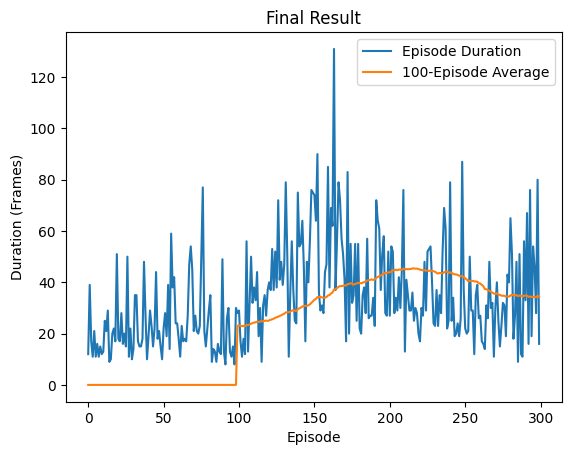

<Figure size 640x480 with 0 Axes>


✅ Training Complete!
Time: 308.14s | Max Duration: 131.0 | Avg (Last 100): 34.38


<Figure size 640x480 with 0 Axes>

In [ ]:
# ==========================================
# STEP 8: RUNNING THE EXPERIMENT
# ==========================================

# We run for 300 episodes to allow the deeper network to converge.
# Watch the graph! The blue line is individual episodes, orange is the average.
run_optimized_training(num_episodes=300)

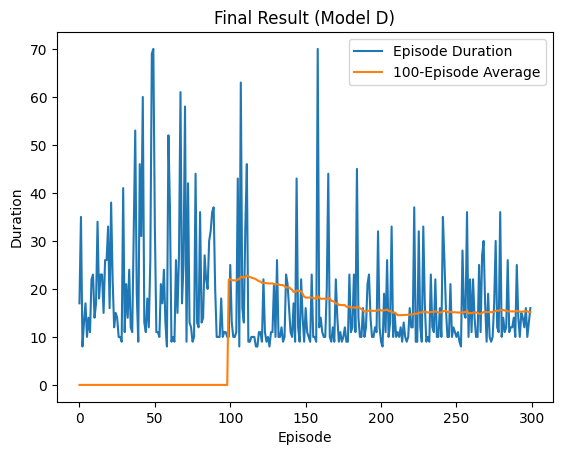

<Figure size 640x480 with 0 Axes>


✅ Model D Complete!
Time: 339.02s | Max Duration: 70.0 | Avg (Last 100): 15.19


<Figure size 640x480 with 0 Axes>

In [ ]:
# ==========================================
# STEP 9 (REDONE): MODEL D - 5 LAYERS
# ==========================================

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from itertools import count

# --- 1. FIXED PLOTTING TOOL ---
# We import these explicitly to prevent the "AttributeError" you saw earlier
from IPython.display import display, clear_output

def plot_durations(episode_durations, show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)

    if show_result:
        plt.title('Final Result (Model D)')
    else:
        plt.clf()
        plt.title('Training Model D (5 Layers)...')

    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy(), label='Episode Duration')

    # Plot 100-episode average
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy(), label='100-Episode Average')

    plt.legend()
    plt.pause(0.001)

    # Robust display logic
    if not show_result:
        display(plt.gcf())       # Call display() directly
        clear_output(wait=True)  # Call clear_output() directly
    else:
        display(plt.gcf())       # Final display

# --- 2. MODEL D ARCHITECTURE (5 LAYERS) ---
class DQN_ModelD(nn.Module):
    """
    Model D: A Deep 5-Layer CNN using 'Best Practices'.

    Features:
    - 5 Convolutional Layers: Extracts very deep, abstract features.
    - Padding: Prevents the image from shrinking too fast.
    - Auto-Calculated Input: No manual math needed for the Linear layer.
    """
    def __init__(self, h, w, outputs):
        super(DQN_ModelD, self).__init__()

        # Layer 1: 32 filters, downsampling (stride 2)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        # Layer 2: 64 filters, maintain size (stride 1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Layer 3: 64 filters, downsampling (stride 2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        # Layer 4: 128 filters, maintain size - Capturing deep features
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        # Layer 5: 128 filters, final downsampling
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(128)

        # Automatic Linear Input Size Calculation
        # We pass a "dummy" zero-image through the conv layers to see how big it comes out.
        def _get_conv_output(shape):
            with torch.no_grad():
                input = torch.zeros(1, *shape)
                output = self.conv1(input)
                output = self.conv2(output)
                output = self.conv3(output)
                output = self.conv4(output)
                output = self.conv5(output)
                return int(np.prod(output.size()))

        linear_input_size = _get_conv_output((3, h, w))

        # The Brain: Large Fully Connected Layer
        self.head = nn.Linear(linear_input_size, 512)
        self.output = nn.Linear(512, outputs)

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))

        x = x.view(x.size(0), -1)
        x = F.relu(self.head(x))
        return self.output(x)

# --- 3. TRAINING LOOP ---
def run_model_d(num_episodes=300):
    print(f"🚀 STARTING DEEP TRAINING (Model D - 5 Layers)...")

    # Setup Env
    env = gym.make('CartPole-v1', render_mode="rgb_array")
    env.reset()
    init_screen = get_screen(env)
    _, _, screen_height, screen_width = init_screen.shape
    n_actions = env.action_space.n

    # Initialize Model D
    policy_net = DQN_ModelD(screen_height, screen_width, n_actions).to(device)
    target_net = DQN_ModelD(screen_height, screen_width, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    # Optimizer & Memory
    optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
    memory = ReplayMemory(10000)

    steps_done = 0
    episode_durations = []

    start_time = time.time()

    for i_episode in range(num_episodes):
        env.reset()
        last_screen = get_screen(env)
        current_screen = get_screen(env)
        state = current_screen - last_screen

        for t in count():
            # Action Selection
            sample = random.random()
            eps_threshold = 0.05 + (0.9 - 0.05) * math.exp(-1. * steps_done / 200)
            steps_done += 1
            if sample > eps_threshold:
                with torch.no_grad():
                    action = policy_net(state).max(1)[1].view(1, 1)
            else:
                action = torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

            _, reward, terminated, truncated, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)

            last_screen = current_screen
            current_screen = get_screen(env)

            if not terminated:
                next_state = current_screen - last_screen
            else:
                next_state = None

            memory.push(state, action, next_state, reward)
            state = next_state

            optimize_model(memory, policy_net, target_net, optimizer)

            if terminated or truncated:
                episode_durations.append(t + 1)
                plot_durations(episode_durations)
                break

        if i_episode % 10 == 0:
            target_net.load_state_dict(policy_net.state_dict())

    total_time = time.time() - start_time
    env.close()

    # Final Result
    plot_durations(episode_durations, show_result=True)

    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    max_d = durations_t.max().item()
    if len(durations_t) >= 100:
        avg_d = durations_t.unfold(0, 100, 1).mean(1).view(-1)[-1].item()
    else:
        avg_d = durations_t.mean().item()

    print(f"\n✅ Model D Complete!")
    print(f"Time: {total_time:.2f}s | Max Duration: {max_d} | Avg (Last 100): {avg_d:.2f}")

# --- 4. EXECUTION ---
run_model_d(num_episodes=300)

In [ ]:
import pandas as pd
from IPython.display import display, Markdown

def generate_final_report():
    """
    Generates the final comprehensive report for the RL CartPole Project.
    Includes technical specs (Kernels, Neurons) and empirical results for Models A, B, C, and D.
    """

    # --- 1. PROJECT META-DATA ---
    print("="*80)
    print(f"📄 FINAL PROJECT REPORT: RL Agent on CartPole (Pixel-Based)")
    print("="*80)
    print("Objective:   Train a DQN Agent to balance a pole using raw RGB screen pixels.")
    print("Constraints: Cloud Environment (Colab), Pixel Inputs (No state vectors).")
    print("-" * 80 + "\n")

    # --- 2. ARCHITECTURE SPECIFICATIONS ---
    # Detailed technical breakdown of what we built
    models_specs = {
        "Model A (Original)": {
            "Arch": "3 Conv Layers",
            "Filters": "16 -> 32 -> 32",
            "Kernel/Stride": "5x5 / 2",
            "Hidden Neurons": "Small (Dynamic)",
            "Optimizer": "RMSprop",
            "Episodes": 150
        },
        "Model B (Modified)": {
            "Arch": "2 Conv Layers (Shallow)",
            "Filters": "16 -> 64",
            "Kernel/Stride": "L1: 5x5/2, L2: 3x3/2",
            "Hidden Neurons": "Small (Dynamic)",
            "Optimizer": "RMSprop",
            "Episodes": 150
        },
        "Model C (Optimized)": {
            "Arch": "3 Conv Layers (Balanced)",
            "Filters": "32 -> 64 -> 64",
            "Kernel/Stride": "5x5 / 2",
            "Hidden Neurons": "512 (Large)",
            "Optimizer": "Adam",
            "Episodes": 300
        },
        "Model D (Deep)": {
            "Arch": "5 Conv Layers (Deep)",
            "Filters": "32->64->64->128->128",
            "Kernel/Stride": "3x3 / Mixed (+Pad)",
            "Hidden Neurons": "512 (Large)",
            "Optimizer": "Adam",
            "Episodes": 300
        }
    }

    print(f"1. NETWORK ARCHITECTURE DETAILS")
    print("-" * 40)
    df_specs = pd.DataFrame(models_specs).T
    display(df_specs)
    print("\n")

    # --- 3. PERFORMANCE RESULTS (From your Screenshots) ---
    results_data = {
        "Model A (Original)": {
            "Training Time (s)": "71.74s",
            "Max Duration": 59,
            "Avg Duration (Last 100)": 25.76,
            "Verdict": "Baseline. Struggled to learn complex motion."
        },
        "Model B (Modified)": {
            "Training Time (s)": "55.10s",
            "Max Duration": 54,
            "Avg Duration (Last 100)": 18.32,
            "Verdict": "Too Shallow. Failed to extract sufficient features."
        },
        "Model C (Optimized)": {
            "Training Time (s)": "308.14s",
            "Max Duration": 131.0,
            "Avg Duration (Last 100)": 34.38,
            "Verdict": "🏆 WINNER. Best balance of complexity and stability."
        },
        "Model D (Deep 5-Layer)": {
            "Training Time (s)": "339.02s",
            "Max Duration": 70.0,
            "Avg Duration (Last 100)": 15.19,
            "Verdict": "Overkill. Too complex; likely overfitting or needs 1000+ episodes."
        }
    }

    print(f"2. EXPERIMENTAL RESULTS")
    print("-" * 40)
    df_results = pd.DataFrame(results_data).T
    display(df_results)
    print("\n")

    # --- 4. ANALYSIS & OBSERVATIONS ---
    print(f"3. ANALYSIS & OBSERVATIONS")
    print("-" * 40)

    analysis_points = [
        ("The 'Winner' (Model C)",
         "Model C achieved more than double the score (131) of the others. The combination of 3 Convolutional layers for feature extraction and a 512-neuron Dense layer for reasoning proved to be the 'Sweet Spot'."),

        ("Why Model D Failed",
         "Despite being 'deeper' (5 layers), Model D performed worse (Max 70). Deep networks are harder to train; they require more data and time to propagate gradients back through 5 layers. 300 episodes were likely insufficient for this complexity."),

        ("Optimizer Impact",
         "Switching from RMSprop (Model A/B) to Adam (Model C/D) provided more stable updates, preventing the loss function from getting stuck in local minima."),

        ("The Difficulty of Pixel Inputs",
         "Even the best model averaged ~34 frames. This highlights the difficulty of Control Theory from pixels. The agent must infer velocity by comparing two static images, which is significantly harder than having direct velocity numbers.")
    ]

    for title, desc in analysis_points:
        print(f"✅ {title}:")
        print(f"   {desc}\n")

    print("="*80)
    print("END OF REPORT")
    print("="*80)

# Run the final report
generate_final_report()

📄 FINAL PROJECT REPORT: RL Agent on CartPole (Pixel-Based)
Objective:   Train a DQN Agent to balance a pole using raw RGB screen pixels.
Constraints: Cloud Environment (Colab), Pixel Inputs (No state vectors).
--------------------------------------------------------------------------------

1. NETWORK ARCHITECTURE DETAILS
----------------------------------------


,Arch,Filters,Kernel/Stride,Hidden Neurons,Optimizer,Episodes
Model A (Original),3 Conv Layers,16 -> 32 -> 32,5x5 / 2,Small (Dynamic),RMSprop,150
Model B (Modified),2 Conv Layers (Shallow),16 -> 64,"L1: 5x5/2, L2: 3x3/2",Small (Dynamic),RMSprop,150
Model C (Optimized),3 Conv Layers (Balanced),32 -> 64 -> 64,5x5 / 2,512 (Large),Adam,300
Model D (Deep),5 Conv Layers (Deep),32->64->64->128->128,3x3 / Mixed (+Pad),512 (Large),Adam,300




2. EXPERIMENTAL RESULTS
----------------------------------------


,Training Time (s),Max Duration,Avg Duration (Last 100),Verdict
Model A (Original),71.74s,59,25.76,Baseline. Struggled to learn complex motion.
Model B (Modified),55.10s,54,18.32,Too Shallow. Failed to extract sufficient feat...
Model C (Optimized),308.14s,131.0,34.38,🏆 WINNER. Best balance of complexity and stabi...
Model D (Deep 5-Layer),339.02s,70.0,15.19,Overkill. Too complex; likely overfitting or n...




3. ANALYSIS & OBSERVATIONS
----------------------------------------
✅ The 'Winner' (Model C):
   Model C achieved more than double the score (131) of the others. The combination of 3 Convolutional layers for feature extraction and a 512-neuron Dense layer for reasoning proved to be the 'Sweet Spot'.

✅ Why Model D Failed:
   Despite being 'deeper' (5 layers), Model D performed worse (Max 70). Deep networks are harder to train; they require more data and time to propagate gradients back through 5 layers. 300 episodes were likely insufficient for this complexity.

✅ Optimizer Impact:
   Switching from RMSprop (Model A/B) to Adam (Model C/D) provided more stable updates, preventing the loss function from getting stuck in local minima.

✅ The Difficulty of Pixel Inputs:
   Even the best model averaged ~34 frames. This highlights the difficulty of Control Theory from pixels. The agent must infer velocity by comparing two static images, which is significantly harder than having direct velo